In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import wandb

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eraldoluis (use `wandb login --relogin` to force relogin)


True

## Load runs

In [3]:
api = wandb.Api()
# sweep_ids = ["1qcd2x0p", "dwqldmag", "s3jg6oju", "cw2quf1k", "68wrws1j", "11su7p2g"]
sweep_ids = ["6wp5xclu", "233pcrb4", "moh4l8qd", "3lvzsurq"]
sweeps = [api.sweep(f"eraldoluis/WeightedCRF_denominator/{sweep_id}") for sweep_id in sweep_ids]

In [4]:
runs = [run for sweep in sweeps for run in sweep.runs]
# run = next(runs)
# next(run.scan_history(keys=["model.label_weights.O", "validation/macro-fscore"]))
len(runs)

233

## Load full history

In [5]:
import pandas as pd 
# import wandb
# api = wandb.Api()

# # Project is specified by <entity/project-name>
# runs = api.runs("eraldoluis/WeightedCRF")

tags = ["O", "PER", "LOC", "ORG", "MISC"]

# columns to select
cols = ["name", "seq_id", "model.label_weights", "_step", "sweep", "model.weight_strategy"]
cols += [f"validation/macro-{m}" for m in ["fscore", "precision", "recall"]]
cols += [f"validation/{tag}-{m}" for tag in tags for m in ["fscore", "precision", "recall"]]

values = []
for seq_id, run in enumerate(runs): 
    # .name is the human-readable name of the run.
    val = {
        "name": run.name,
        "seq_id": seq_id,
        "sweep": run.sweep
    }

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    # val.update({
    #     k: v for k, v in run.config.items() 
    #         if not k.startswith('_') and "label_weights" in k})
    val.update({k: v for k, v in run.config.items() if k in cols})

    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    # val.update({k: v for k, v in run.summary._json_dict.items() if k in cols})

    for hist in run._full_history():
    # for hist in run._sampled_history(["step"]):
        val_ = val.copy()
        val_.update({k: v for k, v in hist.items() if k in cols})
        values.append(val_)

runs_df = pd.DataFrame(values, columns=cols)

In [6]:
runs_df

,name,seq_id,model.label_weights,_step,sweep,model.weight_strategy,validation/macro-fscore,validation/macro-precision,validation/macro-recall,validation/O-fscore,...,validation/PER-recall,validation/LOC-fscore,validation/LOC-precision,validation/LOC-recall,validation/ORG-fscore,validation/ORG-precision,validation/ORG-recall,validation/MISC-fscore,validation/MISC-precision,validation/MISC-recall
0,sparkling-sweep-54,0,{'LOC': 3},14,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,NaN,0.185144,0.187510,0.201439,0.909904,...,0.008574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,sparkling-sweep-54,0,{'LOC': 3},28,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,NaN,0.191556,0.195637,0.204973,0.912665,...,0.026993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,sparkling-sweep-54,0,{'LOC': 3},42,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,NaN,0.258644,0.309414,0.249907,0.929515,...,0.144808,0.122524,0.264241,0.079752,0.052672,0.138776,0.032505,0.000000,0.000000,0.000000
3,sparkling-sweep-54,0,{'LOC': 3},56,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,NaN,0.307086,0.322262,0.329904,0.974015,...,0.463322,0.018100,0.172414,0.009551,0.191875,0.196590,0.187380,0.000000,0.000000,0.000000
4,sparkling-sweep-54,0,{'LOC': 3},70,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,NaN,0.393168,0.389096,0.413136,0.982975,...,0.548110,0.000000,0.000000,0.000000,0.339861,0.303726,0.385755,0.183534,0.273865,0.138013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,lyric-sweep-4,232,{'PER': 0.1},300,<Sweep eraldoluis/WeightedCRF_denominator/3lvz...,emission,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6464,lyric-sweep-4,232,{'PER': 0.1},308,<Sweep eraldoluis/WeightedCRF_denominator/3lvz...,emission,0.792554,0.842045,0.788709,0.992521,...,0.729438,0.679058,0.966490,0.523400,0.698511,0.563269,0.919216,0.833967,0.898089,0.778391
6465,lyric-sweep-4,232,{'PER': 0.1},322,<Sweep eraldoluis/WeightedCRF_denominator/3lvz...,emission,0.800505,0.841171,0.788319,0.992408,...,0.735154,0.710724,0.957895,0.564947,0.724270,0.625827,0.859465,0.819079,0.855670,0.785489
6466,lyric-sweep-4,232,{'PER': 0.1},336,<Sweep eraldoluis/WeightedCRF_denominator/3lvz...,emission,0.736563,0.781626,0.719824,0.992171,...,0.771991,0.551637,0.809612,0.418338,0.759524,0.756641,0.762428,0.682421,0.719406,0.649054


In [7]:
runs_df['model.weight_strategy'].unique()

array([nan, 'lannoy', 'emission_transition', 'emission'], dtype=object)

In [8]:
runs_df['strategy'] = runs_df['model.weight_strategy'].fillna('emission')
runs_df['strategy'].unique()

array(['emission', 'lannoy', 'emission_transition'], dtype=object)

In [9]:
runs_df

,name,seq_id,model.label_weights,_step,sweep,model.weight_strategy,validation/macro-fscore,validation/macro-precision,validation/macro-recall,validation/O-fscore,...,validation/LOC-fscore,validation/LOC-precision,validation/LOC-recall,validation/ORG-fscore,validation/ORG-precision,validation/ORG-recall,validation/MISC-fscore,validation/MISC-precision,validation/MISC-recall,strategy
0,sparkling-sweep-54,0,{'LOC': 3},14,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,NaN,0.185144,0.187510,0.201439,0.909904,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,emission
1,sparkling-sweep-54,0,{'LOC': 3},28,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,NaN,0.191556,0.195637,0.204973,0.912665,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,emission
2,sparkling-sweep-54,0,{'LOC': 3},42,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,NaN,0.258644,0.309414,0.249907,0.929515,...,0.122524,0.264241,0.079752,0.052672,0.138776,0.032505,0.000000,0.000000,0.000000,emission
3,sparkling-sweep-54,0,{'LOC': 3},56,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,NaN,0.307086,0.322262,0.329904,0.974015,...,0.018100,0.172414,0.009551,0.191875,0.196590,0.187380,0.000000,0.000000,0.000000,emission
4,sparkling-sweep-54,0,{'LOC': 3},70,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,NaN,0.393168,0.389096,0.413136,0.982975,...,0.000000,0.000000,0.000000,0.339861,0.303726,0.385755,0.183534,0.273865,0.138013,emission
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,lyric-sweep-4,232,{'PER': 0.1},300,<Sweep eraldoluis/WeightedCRF_denominator/3lvz...,emission,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,emission
6464,lyric-sweep-4,232,{'PER': 0.1},308,<Sweep eraldoluis/WeightedCRF_denominator/3lvz...,emission,0.792554,0.842045,0.788709,0.992521,...,0.679058,0.966490,0.523400,0.698511,0.563269,0.919216,0.833967,0.898089,0.778391,emission
6465,lyric-sweep-4,232,{'PER': 0.1},322,<Sweep eraldoluis/WeightedCRF_denominator/3lvz...,emission,0.800505,0.841171,0.788319,0.992408,...,0.710724,0.957895,0.564947,0.724270,0.625827,0.859465,0.819079,0.855670,0.785489,emission
6466,lyric-sweep-4,232,{'PER': 0.1},336,<Sweep eraldoluis/WeightedCRF_denominator/3lvz...,emission,0.736563,0.781626,0.719824,0.992171,...,0.551637,0.809612,0.418338,0.759524,0.756641,0.762428,0.682421,0.719406,0.649054,emission


## Add individual columns for label weights

In [10]:
base_dict = {k: 1.0 for k in tags}
def transf(w):
    new_d = dict(base_dict)
    new_d.update(w)
    new_d = {f"label_weight_{k}": v for k, v in new_d.items()}
    return pd.Series(new_d)

df_runs_weights = pd.concat([runs_df, runs_df["model.label_weights"].apply(transf)], axis=1)

In [11]:
df_runs_weights.sample(5)

,name,seq_id,model.label_weights,_step,sweep,model.weight_strategy,validation/macro-fscore,validation/macro-precision,validation/macro-recall,validation/O-fscore,...,validation/ORG-recall,validation/MISC-fscore,validation/MISC-precision,validation/MISC-recall,strategy,label_weight_O,label_weight_PER,label_weight_LOC,label_weight_ORG,label_weight_MISC
4044,snowy-sweep-4,146,{'O': 1},168,<Sweep eraldoluis/WeightedCRF_denominator/233p...,lannoy,0.784243,0.775159,0.796237,0.991872,...,0.660612,0.687621,0.676853,0.698738,lannoy,1.0,1.0,1.0,1.0,1.0
3603,wobbly-sweep-18,130,{'PER': 0.5},252,<Sweep eraldoluis/WeightedCRF_denominator/233p...,lannoy,0.866231,0.898569,0.847201,0.993678,...,0.755736,0.805369,0.930714,0.709779,lannoy,1.0,0.5,1.0,1.0,1.0
3429,royal-sweep-24,124,{'PER': 1.5},182,<Sweep eraldoluis/WeightedCRF_denominator/233p...,emission_transition,0.832889,0.861815,0.827705,0.993362,...,0.873327,0.749123,0.843874,0.673502,emission_transition,1.0,1.5,1.0,1.0,1.0
1687,pretty-sweep-86,62,{'LOC': 2},100,<Sweep eraldoluis/WeightedCRF_denominator/233p...,emission_transition,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,emission_transition,1.0,1.0,2.0,1.0,1.0
3032,lemon-sweep-38,110,{'PER': 2},112,<Sweep eraldoluis/WeightedCRF_denominator/233p...,emission_transition,0.517020,0.675888,0.594680,0.992336,...,0.799235,0.401388,0.540000,0.319401,emission_transition,1.0,2.0,1.0,1.0,1.0


## Get only results on the last step

In [12]:
df_last_step = df_runs_weights.groupby("seq_id").last()
df_last_step

,name,model.label_weights,_step,sweep,model.weight_strategy,validation/macro-fscore,validation/macro-precision,validation/macro-recall,validation/O-fscore,validation/O-precision,...,validation/ORG-recall,validation/MISC-fscore,validation/MISC-precision,validation/MISC-recall,strategy,label_weight_O,label_weight_PER,label_weight_LOC,label_weight_ORG,label_weight_MISC
seq_id,,,,,,,,,,,,,,,,,,,,,
0,sparkling-sweep-54,{'LOC': 3},350,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,None,0.801869,0.827973,0.807545,0.993675,0.991639,...,0.823614,0.733538,0.646422,0.847792,emission,1.0,1.0,3.0,1.0,1.0
1,astral-sweep-53,{'LOC': 3},350,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,None,0.808432,0.854724,0.803086,0.994157,0.993507,...,0.896272,0.843284,0.888986,0.802050,emission,1.0,1.0,3.0,1.0,1.0
2,smooth-sweep-52,{'LOC': 3},350,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,None,0.789391,0.852942,0.788787,0.993825,0.992099,...,0.909178,0.831087,0.835726,0.826498,emission,1.0,1.0,3.0,1.0,1.0
3,mild-sweep-51,{'LOC': 3},350,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,None,0.742606,0.852081,0.756880,0.992705,0.990866,...,0.885755,0.823625,0.851727,0.797319,emission,1.0,1.0,3.0,1.0,1.0
4,atomic-sweep-50,{'LOC': 3},350,<Sweep eraldoluis/WeightedCRF_denominator/6wp5...,None,0.684985,0.835411,0.721705,0.994000,0.994244,...,0.911568,0.827953,0.859203,0.798896,emission,1.0,1.0,3.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,royal-sweep-5,{'PER': 0.1},350,<Sweep eraldoluis/WeightedCRF_denominator/3lvz...,emission,0.803468,0.861543,0.795487,0.992119,0.995013,...,0.463671,0.718522,0.789424,0.659306,emission,1.0,0.1,1.0,1.0,1.0
229,neat-sweep-2,{'PER': 0.1},350,<Sweep eraldoluis/WeightedCRF_denominator/3lvz...,emission,0.832616,0.851218,0.827879,0.993491,0.992876,...,0.815488,0.791910,0.920585,0.694795,emission,1.0,0.1,1.0,1.0,1.0
230,absurd-sweep-3,{'PER': 0.1},350,<Sweep eraldoluis/WeightedCRF_denominator/3lvz...,emission,0.829844,0.860872,0.815372,0.993481,0.992577,...,0.828872,0.780355,0.921590,0.676656,emission,1.0,0.1,1.0,1.0,1.0


## Masks of runs with varying weight for each tag
For each tag, create a mask with the runs that vary the weight for this tag.
I.e., all other tags have weight equal to 1.0 except the tag in hand.
Additionally, all runs in which all tags have weight equal to 1.0 are included 
    in the masks of all tags (this is the baseline).

In [13]:
import numpy as np

masks_tag_is_1 = [df_last_step[f"label_weight_{tag}"] == 1.0 for tag in tags]
masks_tag_not_1 = [df_last_step[f"label_weight_{tag}"] != 1.0 for tag in tags]

# verify that only one tag has weight different of 1.0 in all runs
for i_tag, (mask_tag_is_1, mask_tag_not_1) in enumerate(zip(masks_tag_is_1, masks_tag_not_1)):
    if np.any(mask_tag_is_1 & mask_tag_not_1):
        raise AssertionError(f"Inconsistency for tag {tags[i_tag]} ({i_tag})")

# mask for the baseline runs (all tags with weight equal to 1.0)
mask_all_is_1 = np.logical_and.reduce(masks_tag_is_1)

# create masks with varying-weight runs for each tag
masks_tag_var_weight = [mask_tag_not_1 | mask_all_is_1 for mask_tag_not_1 in masks_tag_not_1]

## Number of runs with weight different of 1.0 for each tag

In [14]:
for i_tag, mask in enumerate(masks_tag_not_1):
    print(f"{tags[i_tag]}: {mask.sum()}")

O: 0
PER: 108
LOC: 105
ORG: 0
MISC: 0


### Stratified per weighting strategy

In [15]:
for strategy, df in df_last_step.groupby("strategy"):
    print(f"Strategy: {strategy}")
    for i_tag, mask in enumerate(masks_tag_not_1):
        print(f"\t{tags[i_tag]}: {mask.loc[df.index].sum()}")

Strategy: emission
	O: 0
	PER: 36
	LOC: 36
	ORG: 0
	MISC: 0
Strategy: emission_transition
	O: 0
	PER: 36
	LOC: 33
	ORG: 0
	MISC: 0
Strategy: lannoy
	O: 0
	PER: 36
	LOC: 36
	ORG: 0
	MISC: 0


### DataFrame in long format
This format is necessary for seaborn.

In [42]:
def get_df_melted_var_weight_for_tag(i_tag):
    value_cols = [
        "validation/macro-fscore", 
        f"validation/{tags[i_tag]}-fscore",
        f"validation/{tags[i_tag]}-precision",
        f"validation/{tags[i_tag]}-recall"
    ]
    df = df_last_step[masks_tag_var_weight[i_tag]]
    df_melted = df.melt(id_vars=[f"label_weight_{tags[i_tag]}", "strategy"], value_vars=value_cols)
    df_melted[f"str_label_weight_{tags[i_tag]}"] = df_melted[f"label_weight_{tags[i_tag]}"].map(str)
    df_melted = df_melted.sort_values(["strategy", "variable", f"label_weight_{tags[i_tag]}"])
    return df_melted

In [43]:
get_df_melted_var_weight_for_tag(2)

,label_weight_LOC,strategy,variable,value,str_label_weight_LOC
240,0.1,emission,validation/LOC-fscore,0.352140,0.1
241,0.1,emission,validation/LOC-fscore,0.480268,0.1
242,0.1,emission,validation/LOC-fscore,0.795973,0.1
243,0.1,emission,validation/LOC-fscore,0.628213,0.1
244,0.1,emission,validation/LOC-fscore,0.456859,0.1
...,...,...,...,...,...
75,3.0,lannoy,validation/macro-fscore,0.877241,3.0
76,3.0,lannoy,validation/macro-fscore,0.821386,3.0
77,3.0,lannoy,validation/macro-fscore,0.889338,3.0
78,3.0,lannoy,validation/macro-fscore,0.865850,3.0


## Plots of performances when varying weights

In [47]:
def plot_metrics_var_weight_for_tag(i_tag):
    df = get_df_melted_var_weight_for_tag(i_tag)
    strategies = ['emission', 'emission_transition', 'lannoy']
    _, axs = plt.subplots(1, 3, figsize=(24,6), dpi=300, sharey=True)
    for ax, strategy in zip(axs, strategies):
        legend = (ax == axs[-1])
        sns.lineplot(ax=ax, data=df[df.strategy == strategy], x=f"str_label_weight_{tags[i_tag]}", y="value", hue="variable", sort=False, legend=legend)
        ax.set_title(f"Strategy: {strategy}")
        ax.set_ylim([0.6,1.0])

In [31]:
plt.rcParams.update({'font.size': 16})

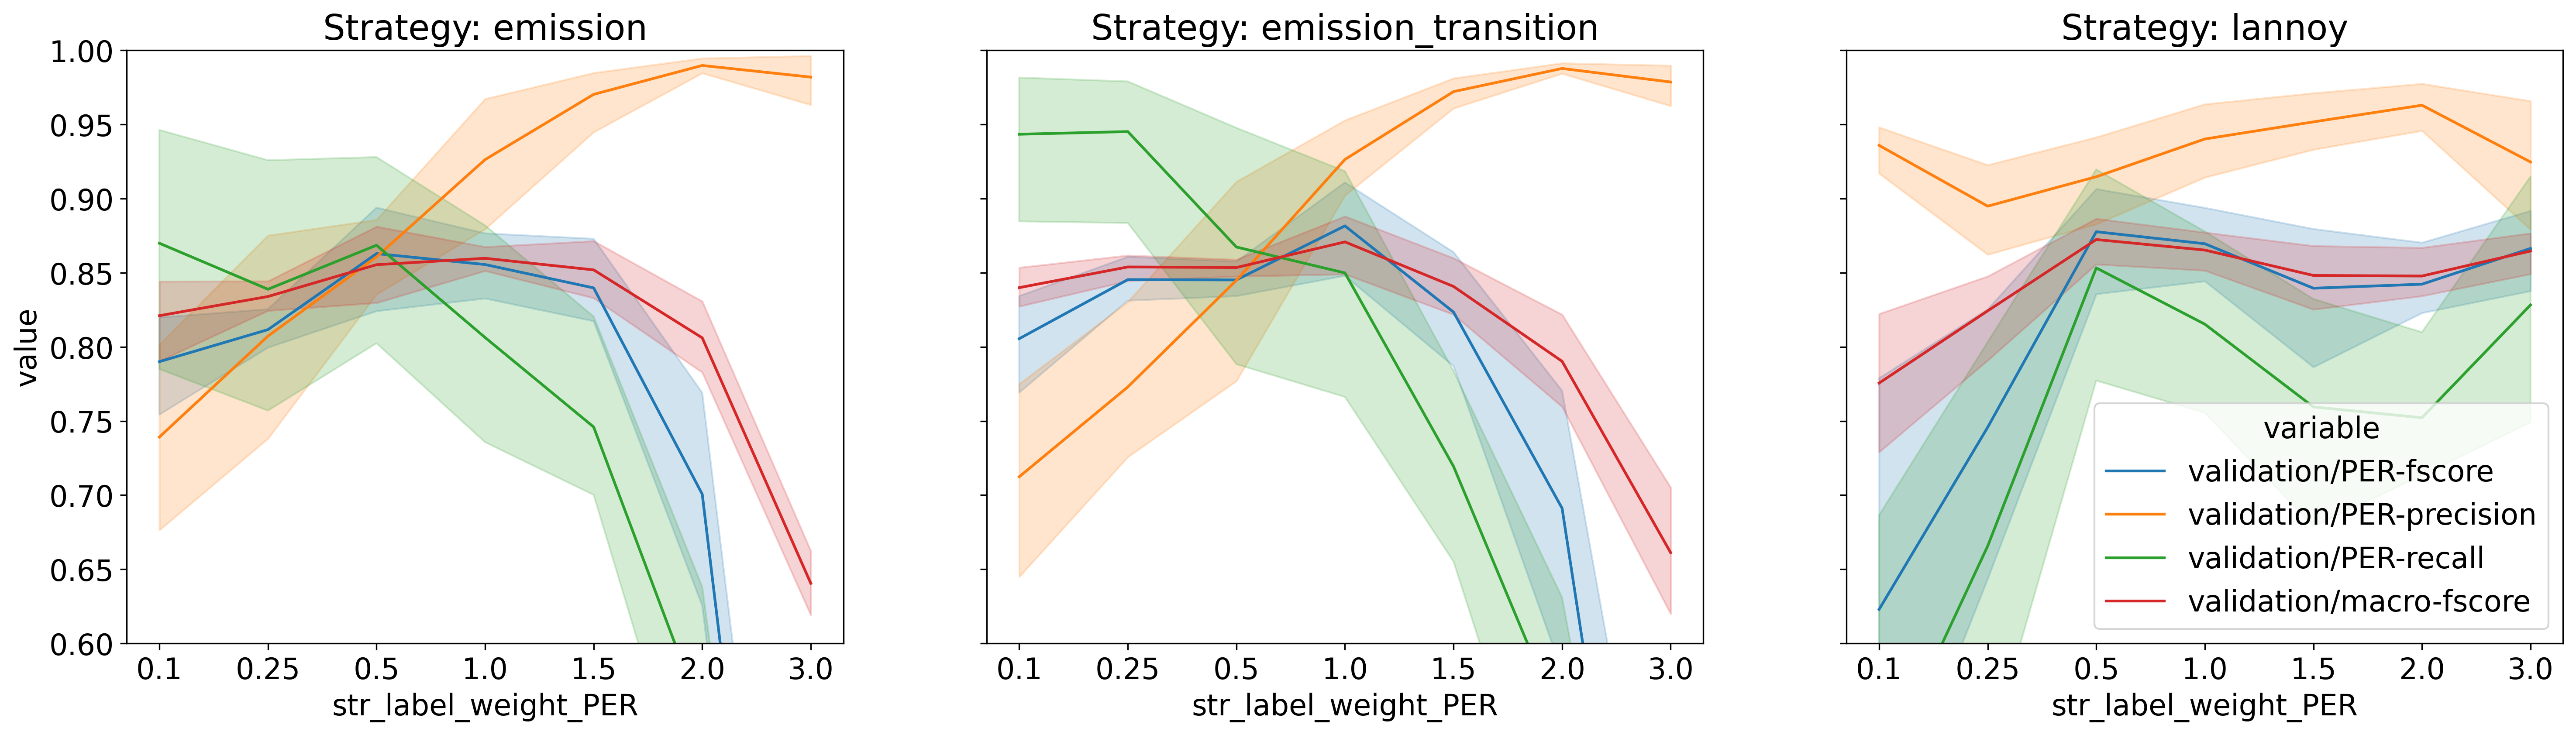

In [48]:
plot_metrics_var_weight_for_tag(1)

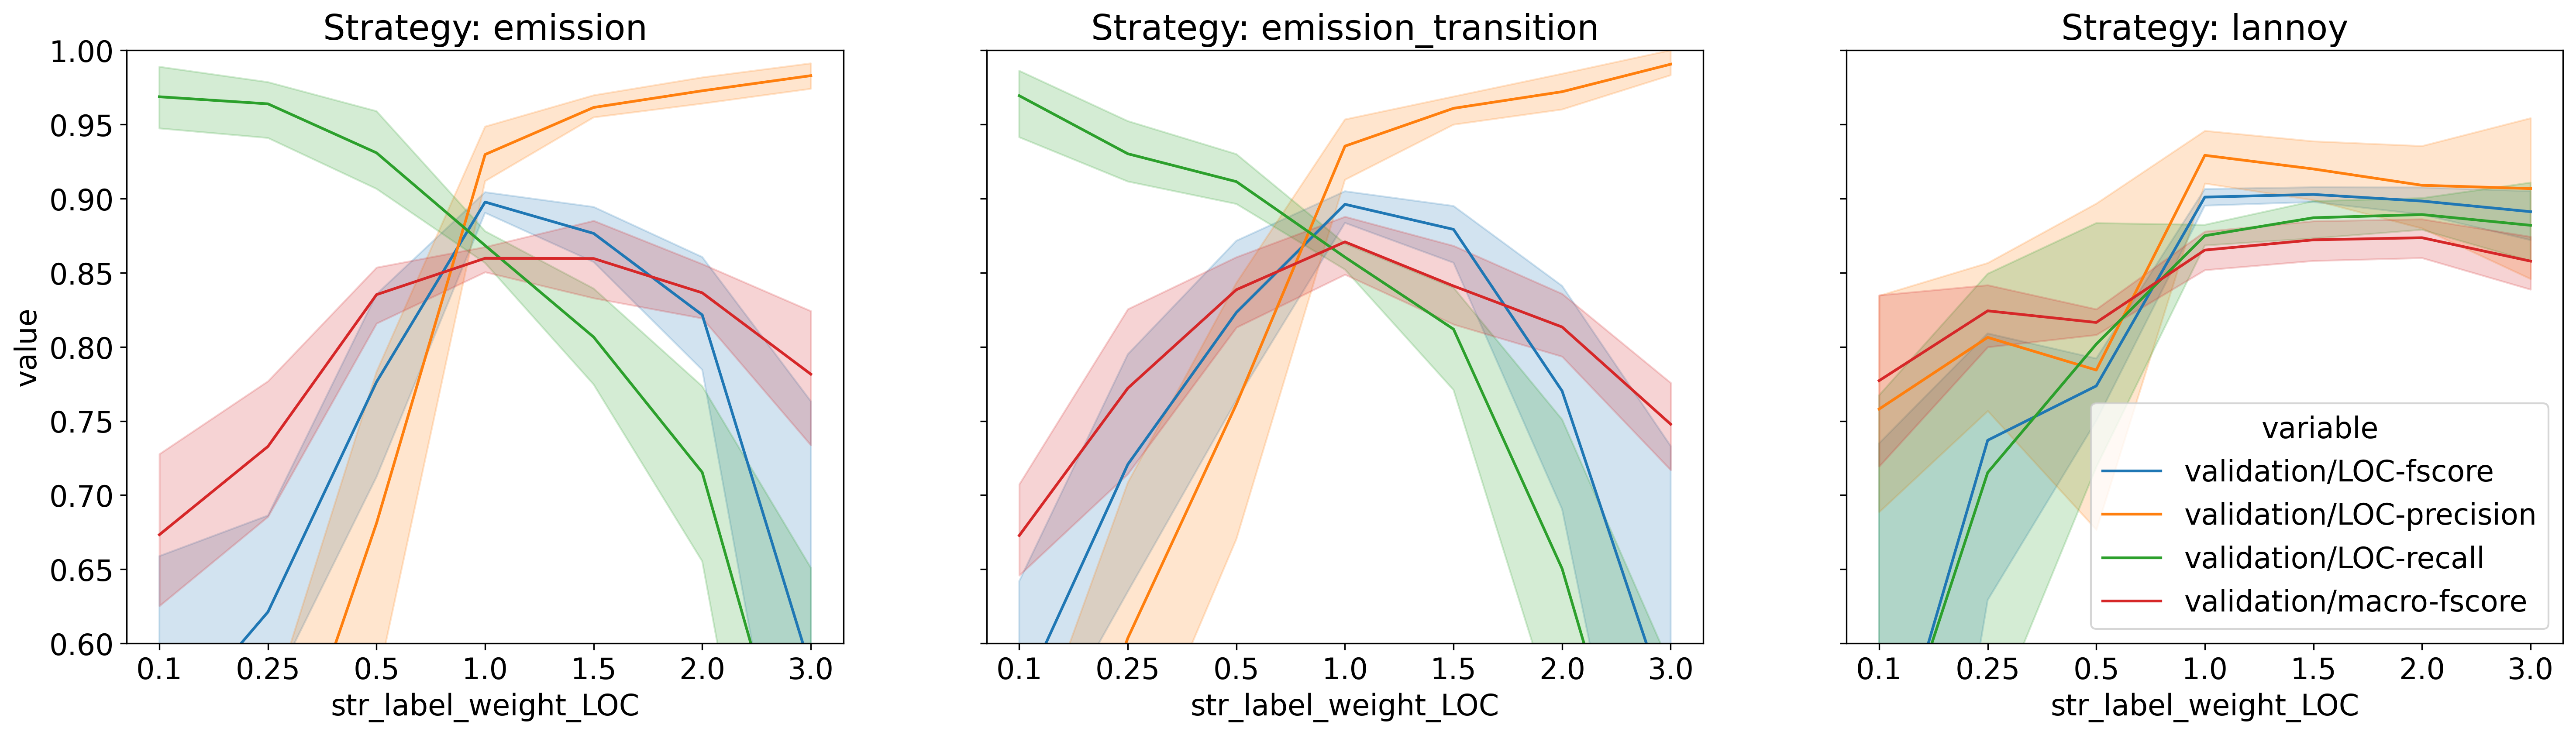

In [49]:
plot_metrics_var_weight_for_tag(2)

## Tables

In [22]:
get_df_melted_var_weight_for_tag(1).groupby(['variable', 'label_weight_PER', 'strategy']).agg(['mean', 'std'])

value  \
                                                                  mean   
variable                label_weight_PER strategy                        
validation/PER-fscore   0.10             emission             0.790016   
                                         emission_transition  0.805508   
                                         lannoy               0.622970   
                        0.25             emission             0.811611   
                                         emission_transition  0.845338   
...                                                                ...   
validation/macro-fscore 2.00             emission_transition  0.790246   
                                         lannoy               0.847762   
                        3.00             emission             0.640509   
                                         emission_transition  0.661203   
                                         lannoy               0.864615   

                                                                        
                                                                   std  
variable                label_weight_PER strategy                       
validation/PER-fscore   0.10             emission             0.043980  
                                         emission_transition  0.046153  
                                         lannoy               0.225460  
                        0.25             emission             0.017931  
                                         emission_transition  0.019985  
...                                                                ...  
validation/macro-fscore 2.00             emission_transition  0.043509  
                                         lannoy               0.024554  
                        3.00             emission             0.029692  
                                         emission_transition  0.059355  
                                         lannoy               0.019306  

[84 rows x 2 columns]